In [98]:
print("Importing dependencies..")
%load_ext autoreload
%autoreload 2
import scipy
import numpy as np
from scipy.linalg import lstsq
from scipy.linalg import norm 
import pandas as pd
import os
from util import RegressionGame
from util_sparse import getShapleyProjection
import os
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm
import shap
import llm_helper

if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('__dcache__'):
    os.makedirs('__dcache__')

N = 6000
print("Explanation count: %s" % N)
k = 100
print("SHAP sample count: %s" % k)
seq_len = 30
print("Seq Length: %s" % seq_len)

# Setup
np.random.seed(1)
model = llm_helper.get_model()

Importing dependencies..
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Explanation count: 6000
SHAP sample count: 100
Seq Length: 30


In [99]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
model = GPT2LMHeadModel.from_pretrained('gpt2').cuda()
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2', use_fast=True)
tokenizer.pad_token = tokenizer.unk_token
test = pd.read_pickle('../mwe_tagger/fsample.pkl')
test['length'] = test['sentence'].str.split().str.len()
test = test[test['length'] > seq_len].copy().reset_index(drop=True)
X = tokenizer(test['sentence'].to_list(), padding=True,  truncation=True, max_length=seq_len, return_tensors ='pt').input_ids
print(X.shape)

In [118]:
# from joblib import Parallel, delayed
# num_cores = 10

def get_prediction_softmax(model, X):
    return scipy.special.softmax(model(X).logits[-1].detach().numpy())

def interaction_value_di(model, X, tokens):
    token1, token2 = tokens
    AB = get_prediction_softmax(model, X)
    
    X_t1 = X.clone()
    X_t1[token1] = tokenizer.unk_token_id
    A = get_prediction_softmax(model, X_t1)
    
    X_t2 = X.clone()
    X_t2[token2] = tokenizer.unk_token_id
    B = get_prediction_softmax(model, X_t2)

    
    X_t12 = X.clone()
    X_t12[token2] = tokenizer.unk_token_id
    X_t12[token1] = tokenizer.unk_token_id
    phi = get_prediction_softmax(model, X_t12)
    
    val = AB - A - B + phi
    val = np.linalg.norm(val)
    return val

def mwe_distance_interaction(encoded_row, row, col):
    iv_mwe = []
    # col = 'weak_mwe' | 'strong_mwe'
    mwes = row[col]
    for mwe in mwes:

        for i in range(len(mwe)):
            for j in range(len(mwe)):
                if i > j:
                    if len([x for x in mwe if x >= seq_len]) > 0:
                        continue
                    iv = interaction_value_di(model, encoded_row, [mwe[i], mwe[j]])
                    iv_mwe.append([iv, abs((mwe[i]-mwe[j])),mwe])
    return iv_mwe
weak_mwe_distance = []
strong_mwe_distance = []

# weak_mwe_distance = Parallel(n_jobs=num_cores)(
#     delayed(mwe_distance_interaction)(X[i], row, 'weak_mwe') for i, row in test.iterrows())

# strong_mwe_distance = Parallel(n_jobs=num_cores)(
#     delayed(mwe_distance_interaction)(X[i], row, 'strong_mwe') for i, row in test.iterrows())


for i, row in test.iterrows():
    if i%100==0:
        print(i, len(test), f'{i*100/len(test)}%')
    weak_mwe_distance.extend(mwe_distance_interaction(X[i], row, 'weak_mwe'))
    strong_mwe_distance.extend(mwe_distance_interaction(X[i], row, 'strong_mwe'))

pd.DataFrame(weak_mwe_distance, columns = ['I', 'posdis', 'ignore']).to_pickle('weak_mwe_distance1.pkl')
pd.DataFrame(strong_mwe_distance, columns = ['I', 'posdis', 'ignore']).to_pickle('strong_mwe_distance1.pkl')

0 2270 0.0%
100 2270 4.405286343612334%
200 2270 8.810572687224669%
300 2270 13.215859030837004%
400 2270 17.621145374449338%
500 2270 22.026431718061673%
600 2270 26.431718061674008%
700 2270 30.837004405286343%
800 2270 35.242290748898675%
900 2270 39.647577092511014%
1000 2270 44.052863436123346%
1100 2270 48.458149779735685%
1200 2270 52.863436123348016%
1300 2270 57.268722466960355%
1400 2270 61.67400881057269%
1500 2270 66.07929515418502%
1600 2270 70.48458149779735%
1700 2270 74.8898678414097%
1800 2270 79.29515418502203%
1900 2270 83.70044052863436%
2000 2270 88.10572687224669%
2100 2270 92.51101321585904%
2200 2270 96.91629955947137%


In [74]:
import os
import datetime
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Fetching Average Distance...")

from joblib import Parallel, delayed

def calculate_interaction(encoded_row, row):
    interactions = []
    for j in range( seq_len):
        for k in range(j+1, seq_len):

            if j+k >= seq_len:
                continue
            if encoded_row[j] == tokenizer.unk_token_id or encoded_row[k] == tokenizer.unk_token_id:
                continue
            
            iv = interaction_value_di(model, encoded_row, [j, k])
            interactions.append([iv, abs(k -j),[j,k]])
    return interactions

average_distance = []
# start_time =  datetime.datetime.now()
# for i, row in test.iterrows():
#     # if i%9 == 0 or i<=100:
#     print(i, len(test), f'{i*100/len(test)}%', (datetime.datetime.now() - start_time).seconds)
#     start_time = datetime.datetime.now()
#     average_distance.extend(calculate_interaction(X[i], row))

num_cores = 9
for x in range(0, len(test), 99):
    print(x, len(test), f'{100*x/len(test)}%')
    average_distance.extend(Parallel(n_jobs=num_cores)(
        delayed(calculate_interaction)(X[i], row) for i, row in tqdm(test[x:x+99].iterrows())))


Fetching Average Distance...
0 5227 0.0%


0it [00:00, ?it/s]

99 5227 1.8940118614884254%


0it [00:00, ?it/s]

198 5227 3.7880237229768507%


0it [00:00, ?it/s]

297 5227 5.682035584465276%


0it [00:00, ?it/s]

396 5227 7.5760474459537015%


0it [00:00, ?it/s]

495 5227 9.470059307442128%


0it [00:00, ?it/s]

594 5227 11.364071168930552%


0it [00:00, ?it/s]

693 5227 13.258083030418979%


0it [00:00, ?it/s]

792 5227 15.152094891907403%


0it [00:00, ?it/s]

891 5227 17.04610675339583%


0it [00:00, ?it/s]

990 5227 18.940118614884256%


0it [00:00, ?it/s]

1089 5227 20.834130476372682%


0it [00:00, ?it/s]

1188 5227 22.728142337861104%


0it [00:00, ?it/s]

1287 5227 24.62215419934953%


0it [00:00, ?it/s]

1386 5227 26.516166060837957%


0it [00:00, ?it/s]

1485 5227 28.410177922326383%


0it [00:00, ?it/s]

1584 5227 30.304189783814806%


0it [00:00, ?it/s]

1683 5227 32.198201645303236%


0it [00:00, ?it/s]

1782 5227 34.09221350679166%


0it [00:00, ?it/s]

1881 5227 35.98622536828008%


0it [00:00, ?it/s]

1980 5227 37.88023722976851%


0it [00:00, ?it/s]

2079 5227 39.774249091256934%


0it [00:00, ?it/s]

2178 5227 41.668260952745364%


0it [00:00, ?it/s]

2277 5227 43.562272814233786%


0it [00:00, ?it/s]

2376 5227 45.45628467572221%


0it [00:00, ?it/s]

2475 5227 47.35029653721064%


0it [00:00, ?it/s]

2574 5227 49.24430839869906%


0it [00:00, ?it/s]

2673 5227 51.13832026018749%


0it [00:00, ?it/s]

2772 5227 53.032332121675914%


0it [00:00, ?it/s]

2871 5227 54.92634398316434%


0it [00:00, ?it/s]

2970 5227 56.82035584465277%


0it [00:00, ?it/s]

3069 5227 58.71436770614119%


0it [00:00, ?it/s]

3168 5227 60.60837956762961%


0it [00:00, ?it/s]

3267 5227 62.50239142911804%


0it [00:00, ?it/s]

3366 5227 64.39640329060647%


0it [00:00, ?it/s]

3465 5227 66.2904151520949%


0it [00:00, ?it/s]

3564 5227 68.18442701358332%


0it [00:00, ?it/s]

3663 5227 70.07843887507174%


0it [00:00, ?it/s]

3762 5227 71.97245073656016%


0it [00:00, ?it/s]

3861 5227 73.8664625980486%


0it [00:00, ?it/s]

3960 5227 75.76047445953702%


0it [00:00, ?it/s]

4059 5227 77.65448632102544%


0it [00:00, ?it/s]

4158 5227 79.54849818251387%


0it [00:00, ?it/s]

4257 5227 81.44251004400229%


0it [00:00, ?it/s]

4356 5227 83.33652190549073%


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [77]:
avg_dist = [item for sublist in average_distance for item in sublist]
pd.DataFrame(avg_dist, columns = ['I', 'posdis', 'ignore']).to_pickle('average_distance1.pkl')

,avg_mean,avg_count,avg_std,weak_mean,weak_count,weak_std,strong_mean,strong_count,strong_std
posdis,,,,,,,,,
1,0.088725,43560,0.087741,0.153940,4439.0,0.158057,0.180148,38.0,0.160068
2,0.083492,39204,0.082559,0.151613,1311.0,0.150937,0.214733,17.0,0.203615
3,0.084349,39204,0.083061,0.159557,382.0,0.158011,0.201323,7.0,0.110625
4,0.081256,34848,0.079479,0.155261,141.0,0.149046,0.178859,4.0,0.128723
5,0.082557,34848,0.080341,0.148696,62.0,0.173875,NaN,NaN,NaN
6,0.079592,30492,0.077142,0.113302,22.0,0.147559,NaN,NaN,NaN
7,0.080966,30492,0.078144,0.051327,5.0,0.018736,NaN,NaN,NaN
8,0.078108,26136,0.075086,0.057945,2.0,0.003534,0.034101,1.0,NaN
9,0.079436,26136,0.075635,0.116987,2.0,0.069131,0.069436,1.0,NaN


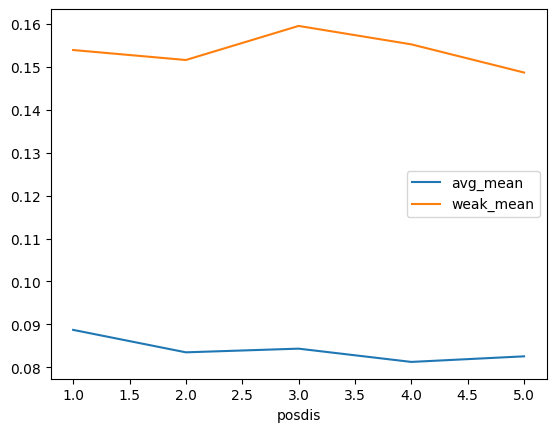

In [231]:

# avg_dist = [item for sublist in average_distance for item in sublist]

def plot_mean(avg_path='average_distance.pkl', weak_path='weak_mwe_distance.pkl', strong_path='strong_mwe_distance.pkl'):
    avg_dist = pd.read_pickle(avg_path)
    avg_df = pd.DataFrame(avg_dist, columns = ['I', 'posdis', 'ignore']).groupby('posdis')['I'].agg( ['mean', 'count', 'std']).rename(columns = {'mean':'avg_mean', 'count':'avg_count', 'std':'avg_std'})
    weak_mwe_distance = pd.read_pickle(weak_path)
    weak_mwe_df = pd.DataFrame(weak_mwe_distance, columns = ['I', 'posdis', 'ignore']).groupby('posdis')['I'].agg( ['mean', 'count', 'std']).rename(columns = {'mean':'weak_mean', 'count':'weak_count', 'std':'weak_std'})
    weak_mwe_df = weak_mwe_df.drop(0)
    strong_mwe_distance = pd.read_pickle(strong_path)
    strong_mwe_df = pd.DataFrame(strong_mwe_distance, columns = ['I', 'posdis', 'ignore']).groupby('posdis')['I'].agg( ['mean', 'count', 'std']).rename(columns = {'mean':'strong_mean', 'count':'strong_count', 'std':'strong_std'})
    abc = pd.concat([avg_df, weak_mwe_df, strong_mwe_df], axis=1)
    display(abc)
    abc = abc[abc['weak_count'] >=50]
    abc[['avg_mean', 'weak_mean']].plot()
    plt.show()
plot_mean()

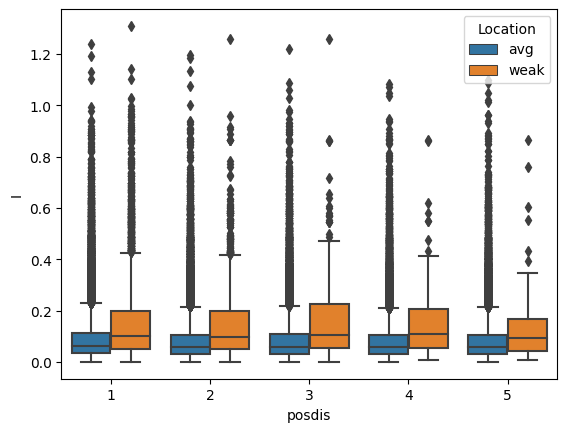

In [233]:
def boxplot_posdis(avg_path='average_distance.pkl', weak_path='weak_mwe_distance.pkl', strong_path='strong_mwe_distance.pkl'):
    avg_dist = pd.read_pickle(avg_path)
    weak_mwe_distance = pd.read_pickle(weak_path)
    strong_mwe_distance = pd.read_pickle(strong_path)
    
    avg_df = pd.DataFrame(avg_dist, columns = ['I', 'posdis', 'ignore']).drop(columns = ['ignore']).assign(Location='avg')
    weak_df = pd.DataFrame(weak_mwe_distance, columns = ['I', 'posdis', 'ignore']).drop(columns = ['ignore']).assign(Location='weak')
    weak_df = weak_df[weak_df['posdis']!=0].copy()
    strong_df = pd.DataFrame(strong_mwe_distance, columns = ['I', 'posdis', 'ignore']).drop(columns = ['ignore']).assign(Location='strong')
    cdf = pd.concat([avg_df, weak_df])#, strong_df])    
    cdf = cdf[cdf['posdis']<=5].copy()
    import seaborn as sns
    import matplotlib.pyplot as plt
    ax = sns.boxplot(x="posdis", y='I',hue="Location", data=cdf)     #hue="Letter",
    plt.show()

boxplot_posdis()

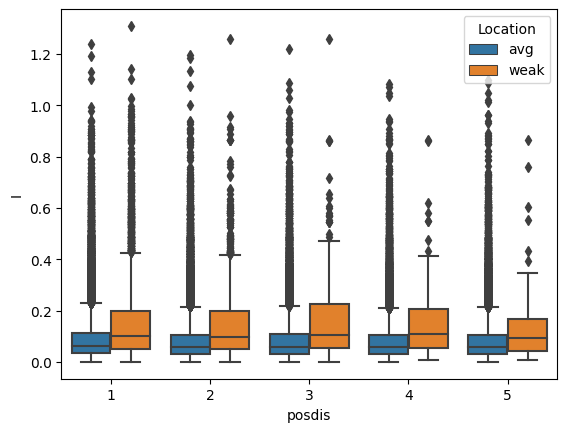

In [151]:
# avg_df.boxplot(column = ['I'], by = 'posdis')

In [152]:
# weak_df

,I,posdis,ignore
0,0.094568,1,"[3, 4]"
1,0.219140,1,"[15, 16]"
2,0.044139,1,"[9, 10]"
3,0.118974,1,"[14, 15]"
4,0.115993,1,"[16, 17]"
...,...,...,...
6446,0.772050,2,"[16, 17, 18]"
6447,0.966493,1,"[16, 17, 18]"
6448,0.590830,1,"[7, 8, 9]"
6449,0.675474,2,"[7, 8, 9]"


In [ ]:
model(X[0:k])

In [ ]:


[x for x in testlist_text if 'Although he wrote' in x]


In [ ]:
pred_mode = 1 # [norm of softmax ]


# TODO: Fix the prediction fn. Might have to incorporate
#  target variable to get the logit for the target variable instead of max
predict_fn = llm_helper.get_prediction_fn(model, pred_mode = pred_mode)



torch.no_grad()

obj = RegressionGame(X = X[0:k], y=None, function = predict_fn, transform = torch.as_tensor)

X_samp = X[k:(N+k)]

shapley_values = np.empty((0, X.shape[1]))
partial_residuals = np.empty((0, X.shape[1]))
games = np.empty((0, 2 ** X.shape[1]))

print("SHape")
print(X.shape[1])

print("  ..ok!")
print("Generating explanations..")

for i in range(0, N):
    example_row = X_samp[i,:].reshape((1,X_samp.shape[1]))
    game = obj.getKernelSHAPGame(example_row)
    games = np.append(games, game.reshape((1,game.shape[0])), axis = 0)
    results, residualGame, origGame = getShapleyProjection(game)
    shapley_values = np.append(shapley_values,
                               np.array([np.flip(results[-1])]), axis=0)
    partial_residuals = np.append(partial_residuals,
                                  np.array([np.flip(norm(residualGame, axis = 0)/norm(origGame, axis = 0))]), axis = 0)
    print("%s/%s samples done." % (i+1, N))
    

    if i % 100 == 0:
        pd.DataFrame(X_samp).to_csv('data/llm_input.csv')
        pd.DataFrame(shapley_values).to_csv('data/llm_shapley_values.csv')
        pd.DataFrame(partial_residuals).to_csv('data/llm_partial_residuals.csv')

print(" Explanations saved to data/llm_*.csv!")

pd.DataFrame(X_samp).to_csv('data/llm_input.csv')
pd.DataFrame(shapley_values).to_csv('data/llm_shapley_values.csv')
pd.DataFrame(partial_residuals).to_csv('data/llm_partial_residuals.csv')

"""
TODO: 
1. How to get base line features for the text generation process? 
2. What is the appropriate metric for shapley score. 
"""

In [ ]:
partial_residuals

In [ ]:
# predict_fn = llm_helper.get_prediction_fn(model, pred_mode = 1)



# torch.no_grad()


# # obj = RegressionGame(X = X[0:k], y=y[0:k], function = predict_fn, transform = torch.as_tensor)
# obj = RegressionGame(X = X[0:k], y=None, function = predict_fn, transform = torch.as_tensor)

# X_samp = X[k:(N+k)]

# shapley_values = np.empty((0, X.shape[1]))
# partial_residuals = np.empty((0, X.shape[1]))
# games = np.empty((0, 2 ** X.shape[1]))

# print("SHape")
# print(X.shape[1])

# print("  ..ok!")
# print("Generating explanations..")

# for i in range(0, N):
#     example_row = X_samp[i,:].reshape((1,X_samp.shape[1]))
#     game = obj.getKernelSHAPGame(example_row)
#     games = np.append(games, game.reshape((1,game.shape[0])), axis = 0)
#     results, residualGame, origGame = getShapleyProjection(game)
#     shapley_values = np.append(shapley_values,
#                                np.array([np.flip(results[-1])]), axis=0)
#     partial_residuals = np.append(partial_residuals,
#                                   np.array([np.flip(norm(residualGame, axis = 0)/norm(origGame, axis = 0))]), axis = 0)
#     print("%s/%s samples done." % (i+1, N))

# print(" Explanations saved to data/llm_*.csv!")

# pd.DataFrame(X_samp).to_csv('data/llm_input.csv')
# pd.DataFrame(shapley_values).to_csv('data/llm_shapley_values.csv')
# pd.DataFrame(partial_residuals).to_csv('data/llm_partial_residuals.csv')

# """
# TODO: 
# 1. How to get base line features for the text generation process? 
# 2. What is the appropriate metric for shapley score. 
# 3. issue here, check why I was not able to make k = 40. model is probably not able to take more than 25. Check
# """

In [ ]:
shapley_values

In [ ]:
partial_residuals